In [1]:
from astropy.io import fits
import galsim
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_laplace, label
from skimage.feature import blob_dog

Below are the outputs of running a single block. Note that in our cluster we have a 2 day limit, so this block did not finish running all the way, as you can see the top of the image is not complete. However, most of the block did run.

Filename: output/rep/_00_00_part1.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (2688, 2688, 4, 1)   float32   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                 2688                                                  NAXIS2  =                 2688                                                  NAXIS3  =                    4                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =              46144.5 / Pixel coordinate of reference point            CRPIX2  =             

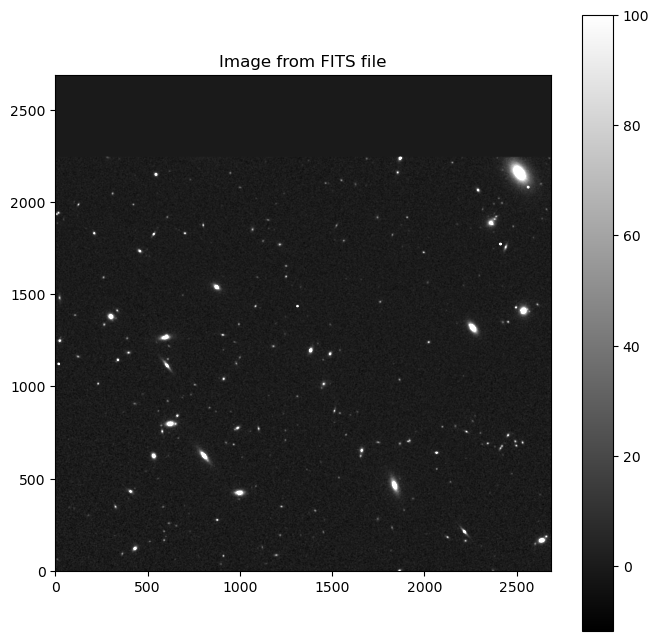

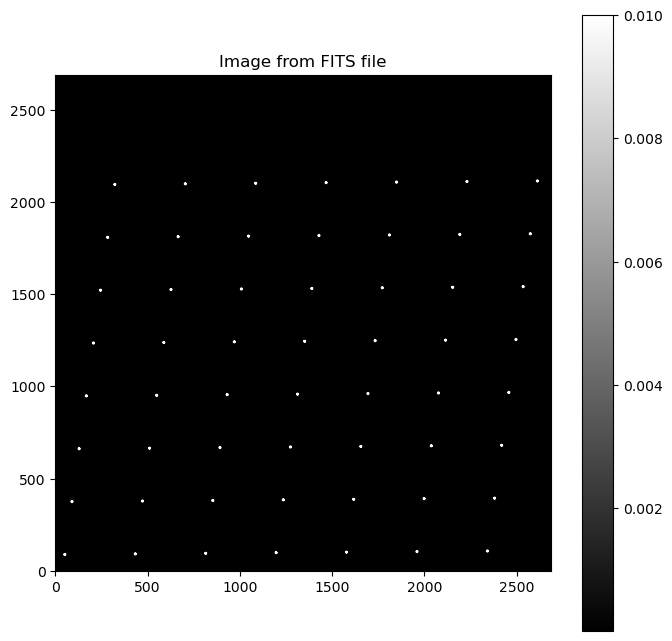

In [42]:
file_name = 'output/rep/_00_00_part1.fits.gz'
with fits.open(file_name) as hdul:
    # Print the header information
    hdul.info()
    
    # Access the data (e.g., first extension or primary HDU)
    data = hdul[0].data
    header = hdul[0].header
    
    # Do something with the data and header
    print(header)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(data[0][0] , cmap='gray', origin='lower', vmax = 100)
#plt.ylim(0,600)
#plt.xlim(30,100)
plt.colorbar()  # Optional: add a color bar
plt.title("Image from FITS file")
plt.show()

# Plot the image
star_grid = data[0][2]#[1000:1500,1200:1500 ]#[280:330,400:450 ]
plt.figure(figsize=(8, 8))
plt.imshow(star_grid  , cmap='gray', origin='lower', vmin=1e-5, vmax=1e-2)
#plt.ylim(1000,1500)
#plt.xlim(1000,1500)
plt.colorbar()  # Optional: add a color bar
plt.title("Image from FITS file")
plt.show()

The code below finds the stars by searching for gaussian blobs. This is just a simple way to find cutouts of the stars to measure shapes

In [43]:

def extract_blob_cutouts(image, cutout_size=100, min_sigma=1e-8, threshold=1e-4):
    """
    Detect Gaussian blobs and extract cutouts centered on each blob.
    
    """
    half_size = cutout_size // 2
    image_height, image_width = image.shape
    
    # Detect blobs using Difference of Gaussians (DoG) method
    blobs = blob_dog(image, min_sigma=min_sigma, threshold=threshold)
    cutouts = []
    positions = []
    
    #blobs = np.sort(blobs)
    for blob in blobs:
        y, x, _ = blob  # y=row, x=col
        y, x = int(y), int(x)
        
        # Ensure the cutout is within image boundaries
        y_min, y_max = max(0, y - half_size), min(image_height, y + half_size)
        x_min, x_max = max(0, x - half_size), min(image_width, x + half_size)
        
        cutout = np.zeros((cutout_size, cutout_size), dtype=image.dtype)
        cutout[
            half_size - (y - y_min) : half_size + (y_max - y),
            half_size - (x - x_min) : half_size + (x_max - x)
        ] = image[y_min:y_max, x_min:x_max]
        
        cutouts.append(cutout)
        positions.append((y, x))
    
    cutouts = [x for _,x in sorted(zip(positions,cutouts))]
    positions = sorted(positions)
    return cutouts, positions


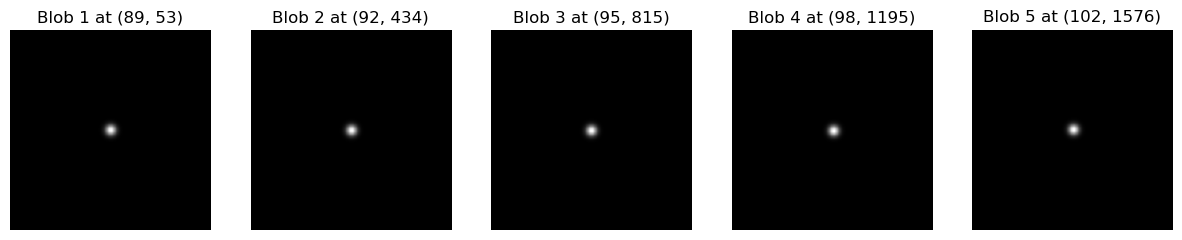

In [44]:
# Extract cutouts
cutouts, positions = extract_blob_cutouts(data[0][2], 150)

# Plot 5 cutouts for visualization
fig, axes = plt.subplots(1, min(5, len(cutouts)), figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(cutouts[i], cmap='gray')
    ax.set_title(f"Blob {i+1} at {positions[i]}")
    ax.axis("off")

plt.show()


In [45]:
# measure psf size using galsim HSM.
outscale = 0.0390625
psf_sizes = []
for cutout in cutouts:
    img_str = galsim.Image(cutout )
    mom = galsim.hsm.FindAdaptiveMom(img_str, strict = False)
    psf_sizes.append(mom.moments_sigma*outscale)
psf_sizes = np.array(psf_sizes)

In [46]:
# print psf size. Show they are systematically 0.107 instead of the desired 0.103.
print(psf_sizes)

[0.10746122 0.10746232 0.10747502 0.10745335 0.10745712 0.10743499
 0.10741537 0.10747446 0.10745751 0.10743602 0.10748367 0.10748602
 0.10744534 0.10744066 0.10749223 0.10747488 0.10745105 0.107449
 0.10744043 0.10745056 0.10742922 0.10748665 0.10749028 0.10745756
 0.10742518 0.10744347 0.10743704 0.10743379 0.1074606  0.107466
 0.107455   0.10743434 0.10745339 0.10744493 0.107456   0.10746988
 0.10743396 0.10745309 0.10745673 0.10745627 0.10745331 0.10743787
 0.10747776 0.10745345 0.10745488 0.10744003 0.10743477 0.10743903
 0.10743022 0.10746554 0.10746902 0.10745571 0.10745057 0.10746344
 0.10743822 0.10744401]


Files created: output/rep/_00_00_part1.fits.gz, output/rep/_00_00_part2.fits.gz
